In [1]:
%pylab inline
import matplotlib.pyplot as plt
import glob
import os
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from livelossplot.tf_keras import PlotLossesCallback
%matplotlib inline

In [3]:
face_dataset_folders=(glob.glob("C:/Users/Fakeha Rahman/Downloads/RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset/*"))
# print(face_dataset_folders)
mask_dataset_folders=(glob.glob("C:/Users/Fakeha Rahman/Downloads/RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/*"))

In [4]:
#To delete some images so that masked and unmasked images are almost equal
# tot=0
# for i in face_dataset_folders:
#     folder=glob.glob(i+"/*")
# #     print(len(folder))
#     tot+=(len(folder))
#     while(len(folder)>6):
#         os.remove(folder[0].replace("\\", "/"))
#         del folder[0]
# print(tot)

2760


In [4]:
def plot_img(img, title):
    imgplot = plt.imshow(img)
    plt.title(title)
    plt.show()

In [10]:
labels=[]
data=[]
def create_data(folder, label):
    num=0
    for i in folder:
        for filename in glob.glob(i+"/*"):
            image = load_img(filename, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
            labels.append(label)
            num+=1
    print(("unmaked" if label==0 else "masked")+ " images = "+str(num))


In [11]:
create_data(face_dataset_folders, 0)   
create_data(mask_dataset_folders, 1)

unmaked images = 2760
masked images = 2203


In [12]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


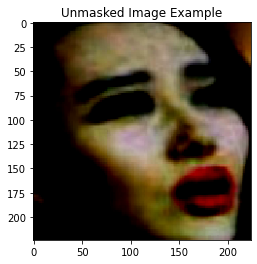

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


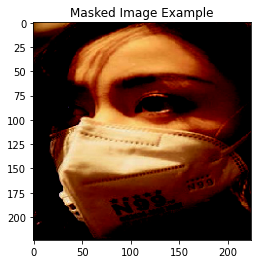

In [18]:
plot_img(data[1], "Unmasked Image Example")
plot_img(data[2760], "Masked Image Example")

In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [18]:
aug = ImageDataGenerator(rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [19]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [20]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32 #batch size

In [21]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network


[INFO] compiling model...


In [22]:
print(labels.shape)
print(data.shape)

(4963, 2)
(4963, 224, 224, 3)


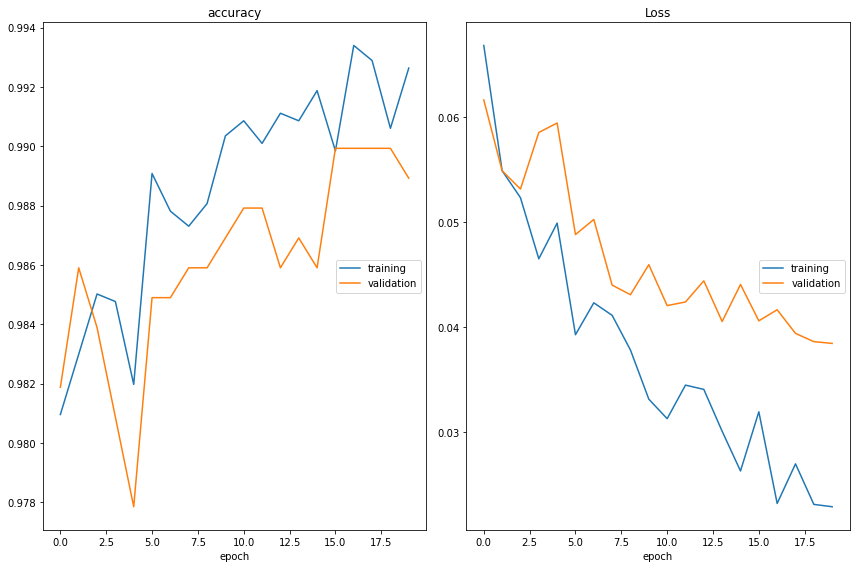

accuracy
	training         	 (min:    0.981, max:    0.993, cur:    0.993)
	validation       	 (min:    0.978, max:    0.990, cur:    0.989)
Loss
	training         	 (min:    0.023, max:    0.067, cur:    0.023)
	validation       	 (min:    0.038, max:    0.062, cur:    0.038)
Wall time: 37min 4s


In [24]:
%%time

callbacks = [PlotLossesCallback()]
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS, callbacks=callbacks)

In [26]:
model.save("Mask_detector_1.h5")

In [27]:
ev=model.evaluate(x=testX, y=testY)

32/32 [==============================] - 21s 642ms/step - loss: 0.0385 - accuracy: 0.9889


In [13]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
model=load_model('Mask_detector_1.h5')

In [17]:
predictions=model.predict(x=testX)
p=np.round(predictions)

In [24]:
print(p)
print(testY)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [29]:
cm=confusion_matrix(y_true=np.argmax(testY, axis=-1), y_pred=np.argmax(predictions, axis=-1))

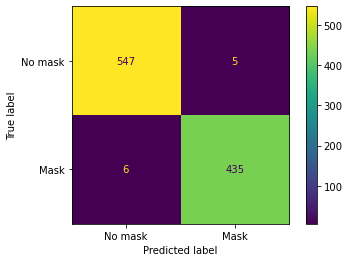

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No mask", "Mask"])
disp = disp.plot()
plt.show()

In [39]:
indices = [i for i,v in enumerate(p) if p[i][0]!=testY[i][0]]
print(indices)
subset_of_wrongly_predicted = [testY[i] for i in indices]

[41, 58, 228, 350, 560, 573, 623, 668, 823, 829, 830]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


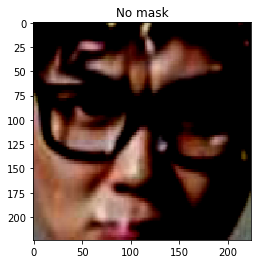

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


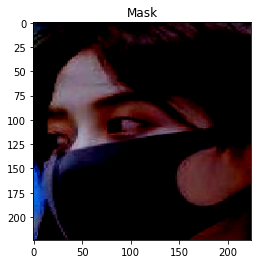

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


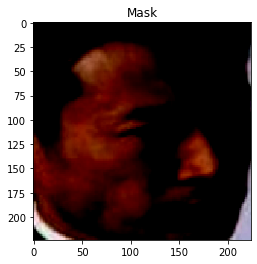

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


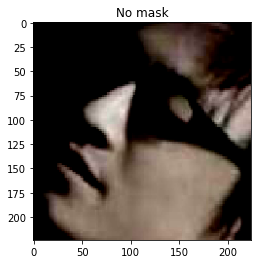

In [50]:
test_data=np.array([testX[100], testX[72], testX[350], testX[600]])
test_preds=np.round(model.predict(test_data))
print(test_preds)
for i in range(len(test_preds)):
    plot_img(test_data[i], "Mask" if test_preds[i][0]==0 else "No mask")